# Choropleth quantitative classification

In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd 
import pysal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mx = gpd.read_file("../data/mexico/mexicojoin.shp")
print(mx[['NAME', 'PCGDP1940']].head())

                    NAME  PCGDP1940
0  Baja California Norte    22361.0
1    Baja California Sur     9573.0
2                Nayarit     4836.0
3                Jalisco     5309.0
4         Aguascalientes    10384.0


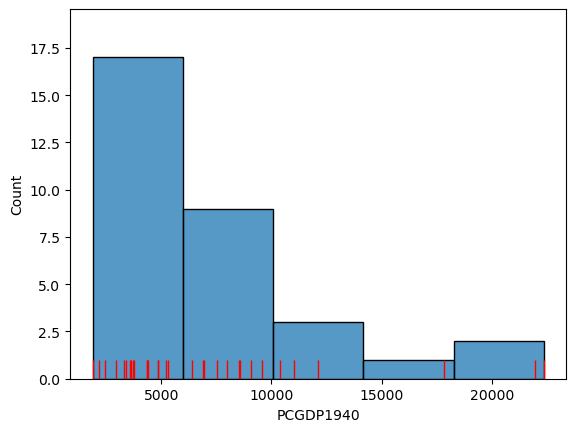

In [3]:
ax = sns.histplot(mx.PCGDP1940, bins=5)
sns.rugplot(mx.PCGDP1940, height=0.05, color='r', ax=ax);

In [4]:
mx.PCGDP1940.describe()

count       32.000000
mean      7230.531250
std       5204.952883
min       1892.000000
25%       3701.750000
50%       5256.000000
75%       8701.750000
max      22361.000000
Name: PCGDP1940, dtype: float64

In [5]:
mx.PCGDP1940.max()

np.float64(22361.0)

In [6]:
print(mx.sort_values('PCGDP1940', ascending=False)[["NAME", "PCGDP1940"]].iloc[:5])

                     NAME  PCGDP1940
0   Baja California Norte    22361.0
16           Quintana Roo    21965.0
10       Distrito Federal    17816.0
26                Durango    12132.0
6    Queretaro de Arteaga    11016.0


>Distribution is positively skewed, the mean exceeds the median, resulting in the long right tail.
>
>Positive skewness is common in regional income studies
>
>Skewness affects choice of classification scheme

In [7]:
counts, bins, patches = ax.hist(mx.PCGDP1940, bins=5)

In [8]:
counts, bins

(array([17.,  9.,  3.,  1.,  2.]),
 array([ 1892. ,  5985.8, 10079.6, 14173.4, 18267.2, 22361. ]))

This yields five bins, with the first having a lower bound of 1892 and an upper bound of 5985.8 which contains 17 observations. The determination of the interval width ($w$) and the number of bins in `seaborn` is based on the Freedman-Diaconis rule [FD81]:
$$
w = 2 * IQR * n^{-1/3}
$$

where $IQR$ is the inter quartile range of the attribute values. Given $w$, the number of bins ($k$) is:

$$
k = \dfrac{(max-min)}{w}
$$


>`mapclassify` has various classification algorithms which focus on different priorities

In [9]:
import mapclassify

## Equal intervals

- each bin has the same width in the values space
- simple and easy to interpret
- can result in sparse classes

In [10]:
ei5 = mapclassify.EqualInterval(mx.PCGDP1940, k=5)
ei5

EqualInterval

      Interval         Count
----------------------------
[ 1892.00,  5985.80] |    17
( 5985.80, 10079.60] |     9
(10079.60, 14173.40] |     3
(14173.40, 18267.20] |     1
(18267.20, 22361.00] |     2

## Quantiles

- avoids sparse classes
- can identify class boundaries
- varying widths can make interpretation difficult
- a large number of duplicate values can make the limits become ambiguous

In [11]:
q5 = mapclassify.Quantiles(mx.PCGDP1940, k=5)
q5

Quantiles

      Interval         Count
----------------------------
[ 1892.00,  3576.20] |     7
( 3576.20,  4582.80] |     6
( 4582.80,  6925.20] |     6
( 6925.20,  9473.00] |     6
( 9473.00, 22361.00] |     7

>Example of duplicate value problem

In [12]:
np.random.seed(12345)
x = np.random.randint(0, 10, 20)
x[0:10] = x.min() 
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [13]:
ties = mapclassify.Quantiles(x, k=5)
ties

/nix/store/vr0vzbdxcp8p7930zzjipn2i2gfn14ii-python3-3.12.8-env/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


Quantiles

  Interval     Count
--------------------
[0.00, 0.00] |    11
(0.00, 1.40] |     1
(1.40, 6.20] |     4
(6.20, 9.00] |     4

## Mean-standard deviation

Appropriate for normally distributed data.

Parameters include: 

multiples : numpy.array (default [-2, -1, 1, 2])
    The multiples of the standard deviation to add/subtract from
    the sample mean to define the bins.

k = number of classes

In [14]:
msd = mapclassify.StdMean(mx.PCGDP1940)
msd

StdMean

      Interval         Count
----------------------------
(    -inf, -3179.37] |     0
(-3179.37,  2025.58] |     1
( 2025.58, 12435.48] |    28
(12435.48, 17640.44] |     0
(17640.44, 22361.00] |     3

## Maximum breaks

- Determines breaks based on the differences of sorted values
- places k-1 breakpoints where pair value differences is greatest
- good if the distribution is not unimodal
- results can be misleading

In [15]:
mb5 = mapclassify.MaximumBreaks(mx.PCGDP1940, k=5)
mb5

MaximumBreaks

      Interval         Count
----------------------------
[ 1892.00,  5854.00] |    17
( 5854.00, 11574.00] |    11
(11574.00, 14974.00] |     1
(14974.00, 19890.50] |     1
(19890.50, 22361.00] |     2

## Boxplot 

- blend of quantile and std classifiers.
- values in the extrmeme classes considered outliers
- takes a `hinge` parameter, a multiplier of $IQR$ for the whisker bounds, default 1.5

In [16]:
bp = mapclassify.BoxPlot(mx.PCGDP1940)
bp

BoxPlot

      Interval         Count
----------------------------
(    -inf, -3798.25] |     0
(-3798.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 16201.75] |     5
(16201.75, 22361.00] |     3

In [17]:
bp1 = mapclassify.BoxPlot(mx.PCGDP1940, hinge=1)
bp1

BoxPlot

      Interval         Count
----------------------------
(    -inf, -1298.25] |     0
(-1298.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 13701.75] |     5
(13701.75, 22361.00] |     3

## Head-tail breaks 

- recursively splits around iterative means, continues until the distributions _in each class_ do not have heavy tails
- good for power and log normal distributions

In [18]:
ht = mapclassify.HeadTailBreaks(mx.PCGDP1940)
ht

HeadTailBreaks

      Interval         Count
----------------------------
[ 1892.00,  7230.53] |    20
( 7230.53, 12244.42] |     9
(12244.42, 20714.00] |     1
(20714.00, 22163.00] |     1
(22163.00, 22361.00] |     1

## Jenks-Caspall breaks

- minimize the sum of absolute deviations around class means
- starts with predetermined number of classes and arbitrary intial breaks, eg. quantiles
- attempts to improve by moving observations between adjacent classes
- moves resulting in the largest reductin of the objective function are made
- repeats until no further improvement possible
- this is 1-dimenstional K-Means clustering
- heuristic

In [19]:
np.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx.PCGDP1940, k=5)
jc5

JenksCaspall

      Interval         Count
----------------------------
[ 1892.00,  2934.00] |     4
( 2934.00,  4414.00] |     9
( 4414.00,  6399.00] |     5
( 6399.00, 12132.00] |    11
(12132.00, 22361.00] |     3

## Fisher-Jenks breaks

- non-heuristic, guaranteed result

In [20]:
np.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx.PCGDP1940, k=5)

fj5

/nix/store/vr0vzbdxcp8p7930zzjipn2i2gfn14ii-python3-3.12.8-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: Numba not installed. Using slow pure python version.
  exec(code_obj, self.user_global_ns, self.user_ns)


FisherJenks

      Interval         Count
----------------------------
[ 1892.00,  5309.00] |    17
( 5309.00,  9073.00] |     8
( 9073.00, 12132.00] |     4
(12132.00, 17816.00] |     1
(17816.00, 22361.00] |     2

## Max-p 

- similar to JC

In [21]:
mp5 = mapclassify.MaxP(mx.PCGDP1940, k=5)
mp5

MaxP

      Interval         Count
----------------------------
[ 1892.00,  3569.00] |     7
( 3569.00,  5309.00] |    10
( 5309.00,  7990.00] |     5
( 7990.00,  9573.00] |     4
( 9573.00, 22361.00] |     6

# Comparing Schemes

- can use Absolute Deviation around Class Medians (ADCM) to measure fit
  

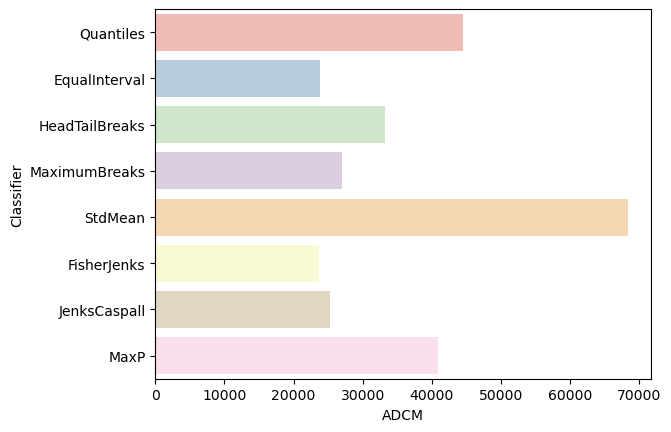

In [23]:
class5 = q5, ei5, ht, mb5, msd, fj5, jc5, mp5
fits = np.array([c.adcm for c in class5])
adcms = pd.DataFrame(fits)
adcms["classifier"] = [c.name for c in class5]
adcms.columns = ["ADCM", "Classifier"]
ax = sns.barplot(
    y="Classifier", 
    x="ADCM", 
    data=adcms, 
    hue='Classifier', palette="Pastel1"
)

>Compare how each instance was classified in each scheme

In [24]:
mx["Quantiles"] = q5.yb
mx["Equal Interval"] = ei5.yb
mx["Head-Tail Breaks"] = ht.yb
mx["Maximum Breaks"] = mb5.yb
mx["Mean-Standard Deviation"] = msd.yb
mx["Fisher-Jenks"] = fj5.yb
mx["Jenks Caspall"] = jc5.yb
mx["MaxP"] = mp5.yb

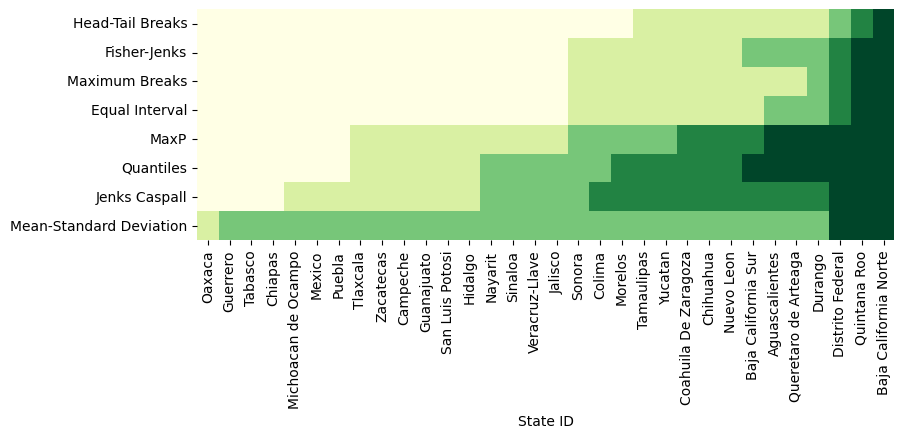

In [25]:
f, ax = plt.subplots(1, figsize=(9,3))
sns.heatmap(
    mx.set_index('NAME')
    .sort_values('PCGDP1940')[[
            "Head-Tail Breaks",
            "Fisher-Jenks",
            "Maximum Breaks",
            "Equal Interval",
            "MaxP",
            "Quantiles",
            "Jenks Caspall",
            "Mean-Standard Deviation",
    ]]
    .T, 
    cmap='YlGn', 
    cbar=False, 
    ax=ax
)
ax.set_xlabel("State ID");

>Compare number of values assigned to each class across the different classifiers (meso-level view)

In [26]:
print(pd.DataFrame(
    {c.name: c.counts for c in class5}, 
    index=["class-{}".format(i) for i in range(5)]
))

         Quantiles  EqualInterval  HeadTailBreaks  MaximumBreaks  StdMean  \
class-0          7             17              20             17        0   
class-1          6              9               9             11        1   
class-2          6              3               1              1       28   
class-3          6              1               1              1        0   
class-4          7              2               1              2        3   

         FisherJenks  JenksCaspall  MaxP  
class-0           17             4     7  
class-1            8             9    10  
class-2            4             5     5  
class-3            1            11     4  
class-4            2             3     6  
